<a href="https://colab.research.google.com/github/VatsalyaDubey16/Transfer_Learning_Models/blob/main/Transfer_Learning_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Transfer Learning with Tensorflow: Feature Extraction
---

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and more.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called transfer learning, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

  1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
  2.Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.
  
What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as ImageNet (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
!nvidia_smi

'nvidia_smi' is not recognized as an internal or external command,
operable program or batch file.


# Transfer leanring with TensorFlow Hub: Getting great results with 10% of the data
---

* [TensorFlow Hub](https://www.tensorflow.org/hub) is a repository for existing model components. It makes it so you can import and use a fully trained model with as little as a URL.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)

Transfer learning often allows you to get great results with less data.

Download a subset of the data we've been using, namely 10% of the training data from the 10_food_classes dataset and use it to train a food image classifier on.

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the download file
zip_ref = zipfile.ZipFile("Downloads/10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("Downloads/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Downloads/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'Downloads/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'Downloads/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'Downloads/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'Downloads/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'Downloads/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'Downloads/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'Downloads/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'Downloads/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'Downloads/10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 'Downloads

# Creating data loaders(preparing the data)
---

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (244,244)
BATCH_SIZE = 32

train_dir = "Downloads/10_food_classes_10_percent/train/"
test_dir = "Downloads/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)\

print("Training images")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size= IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical")

print("Testing images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size= IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Training images
Found 750 images belonging to 10 classes.
Testing images
Found 2500 images belonging to 10 classes.


# Setting up callbacks(things to run whilst our model trains)

In [ ]:
# Create tensorboard callback function
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

# Creating models using Tensorflow Hub
---

We're going to use two models from TensorFlow Hub:

  1.**ResNetV2** - a state of the art computer vision model architecture from 2016.

  2.**EfficientNet** - a state of the art computer vision architecture from 2019.


![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V1 feature vector
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/feature-vector/versions/1"

# Original: EfficientNetB5 feature vector
efficientnet_url ="https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b7-feature-vector/versions/1"

# Mobilenet_V2
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [ ]:

# Create a function. This function will take a model's Tensorflow Hub URL
def create_model(model_url, num_classes=10):
    """
    Take a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Returns:
      An uncompiled Keras Sequential model with model_url
    """

    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,  # freeze the underlying patterns
                                             name="feature_extraction_layer",
                                             input_shape=(224, 224, 3))  # define the input image shape

    # Create our own model
    model = tf.keras.Sequential([
        layers.Lambda(lambda x: tf.image.resize(x, (224, 224))),  # Resize input images
        tf.keras.layers.Lambda(lambda x: hub.KerasLayer(feature_extractor_layer)(x),
                           input_shape=IMAGE_SHAPE+(3,)),
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model


>**layers.Lambda(lambda x: tf.image.resize(x, (224, 224))):** This line adds a Lambda layer to the model. A Lambda layer allows you to apply a custom function to the input data. In this case, the custom function is a lambda function, which takes input x (representing a batch of images) and resizes each image in the batch to a target size of (224, 224) using TensorFlow's tf.image.resize() function.

## Resnet Model
---

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)

What our current model looks like. A ResNet50V2 backbone with a custom dense layer on top (10 classes instead of 1000 ImageNet classes).

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes= train_data.num_classes)

# Compile
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs =5,
                                  steps_per_epoch = len(train_data),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnet50V2")])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20240312-190115
Epoch 1/5


C:\Users\vatsa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.2004 - loss: 2.5503 - val_accuracy: 0.5760 - val_loss: 1.2339
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.6928 - loss: 0.9783 - val_accuracy: 0.7500 - val_loss: 0.8030
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.8552 - loss: 0.5979 - val_accuracy: 0.7852 - val_loss: 0.6897


# Checking model's training curves
---

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label ='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.legend();


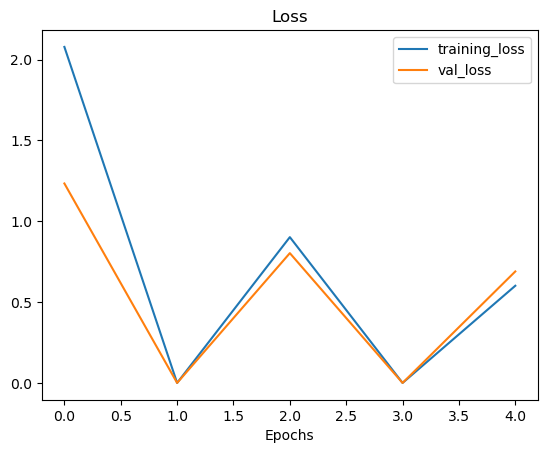

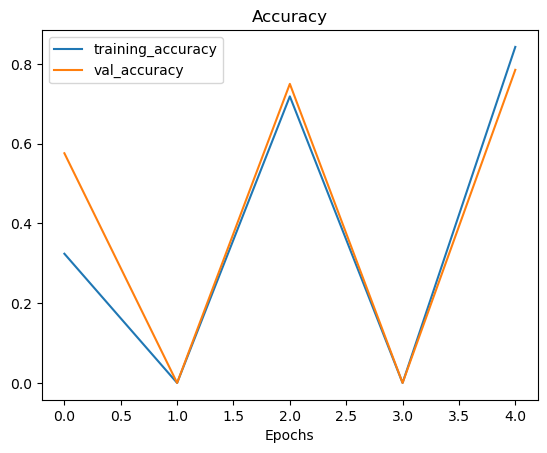

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_10 (Lambda)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_11 (Lambda)                   │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,472 (240.13 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,982 (160.09 KB)

In [ ]:
# 2D plot of model

from tensorflow.keras.utils import plot_model
def model_plot(model_name):
  plot_model(model_name, show_shapes=True)

In [ ]:
model_plot(resnet_model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Efficientnet Model
---

![](https://wisdomml.in/wp-content/uploads/2023/03/eff_banner.png)

In [ ]:
# Create model
efficientnet_model = create_model(model_url = efficientnet_url ,
                                  num_classes = train_data.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs =5,
                                  steps_per_epoch = len(train_data),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnet50V2")])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20240312-190819
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 320s 13s/step - accuracy: 0.3855 - loss: 1.9657 - val_accuracy: 0.7988 - val_loss: 0.9976
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 292s 13s/step - accuracy: 0.7956 - loss: 0.8939 - val_accuracy: 0.8404 - val_loss: 0.6767
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 294s 13s/step - accuracy: 0.8480 - loss: 0.6059 - val_accuracy: 0.8452 - val_loss: 0.5824


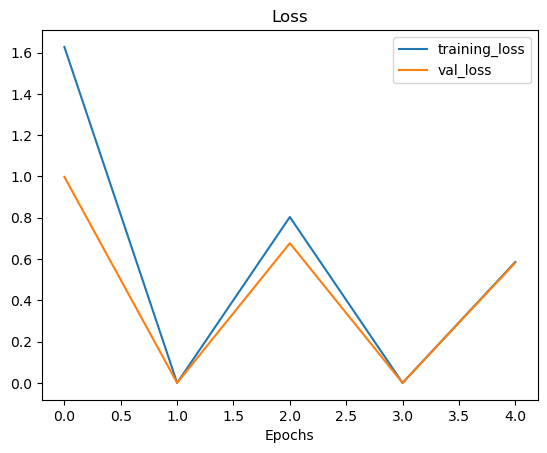

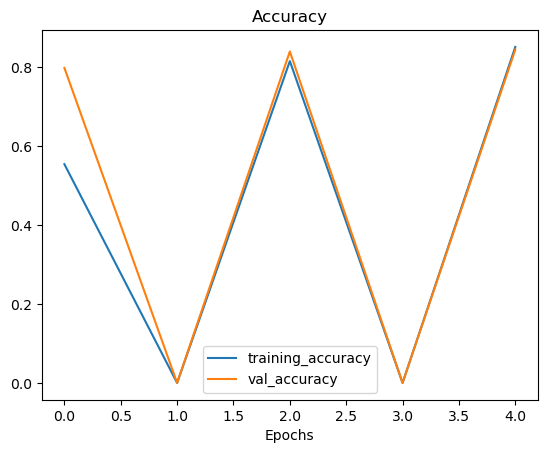

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_12 (Lambda)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_13 (Lambda)                   │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          25,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,832 (300.13 KB)

 Trainable params: 25,610 (100.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,222 (200.09 KB)

In [ ]:
model_plot(efficientnet_model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## MobileNet Model
---

![](https://www.researchgate.net/publication/342856036/figure/fig3/AS:911929400885251@1594432320422/The-architecture-of-the-MobileNetv2-network.ppm)

In [ ]:
# Create model
mobilenet_model = create_model(model_url = mobilenet_url,
                                  num_classes = train_data.num_classes)

# Compile EfficientNet model
mobilenet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

# Fit EfficientNet model
mobilenet_history = mobilenet_model.fit(train_data,
                                  epochs =5,
                                  steps_per_epoch = len(train_data),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnet50V2")])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20240312-192326
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1961 - loss: 2.3253 - val_accuracy: 0.6124 - val_loss: 1.3135
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6848 - loss: 1.0831 - val_accuracy: 0.7348 - val_loss: 0.8878
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7837 - loss: 0.7308 - val_accuracy: 0.7724 - val_loss: 0.7623


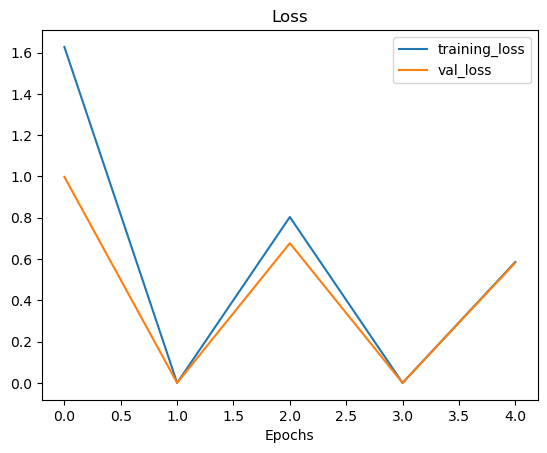

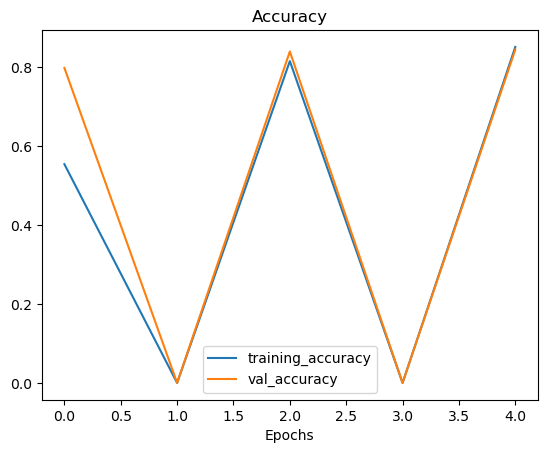

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_12 (Lambda)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_13 (Lambda)                   │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          25,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,832 (300.13 KB)

 Trainable params: 25,610 (100.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,222 (200.09 KB)

In [ ]:
model_plot(efficientnet_model)

You must install pydot (`pip install pydot`) for `plot_model` to work.
